In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import copy
import random
import importlib
from dataUtils import *
from torch.nn import functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from collections import defaultdict
from torch.utils.data import TensorDataset, DataLoader

In [2]:
bkdatafolder = "/Volumes/T7 Touch/TheseProject/DR_KELLA/BKDataCleaned/"
dataset_name = os.listdir(bkdatafolder)

In [3]:
date1 = "2019-03-07"
date2 = "2019-12-31"
floor_dict = createDictFloor("Floor7", dataset_name, bkdatafolder)
for data in floor_dict.keys():
    zone = floor_dict[data]
    print("{} Start: {} End: {} Count:{}".format(data,zone.index.min(),zone.index.max(), zone.shape[0]))
    print("")

Floor7Z1 Start: 2019-03-06 14:50:00 End: 2019-12-31 23:59:00 Count:424099

Floor7Z2 Start: 2019-03-06 14:48:00 End: 2019-12-31 23:59:00 Count:424701

Floor7Z4 Start: 2019-03-06 14:46:00 End: 2019-12-31 23:59:00 Count:416243

Floor7Z5 Start: 2019-03-06 14:55:00 End: 2019-12-31 23:59:00 Count:407698



In [44]:
myfloor = "Floor7Z1"
lookback = 13
lookahead = 5
batch_size = 5

In [45]:
featureX = ["temperature"]
resampleX_method = "max"
resampleX, scalersX, index_nan = createDTFeat(date1, date2, floor_dict, featureX,
                                              resample_method=resampleX_method)
cleanedDataX, remain_date = cleanNan(resampleX, index_nan)

In [46]:
cutting_date = "2019-07-08"
cutting_date2 = "2019-08-09"
train_date, test_date = splitDate(remain_date, cutting_date)
valid_date, test_date = splitDate(test_date, cutting_date2)
databyDateX = createDataByDate(cleanedDataX, featureX, remain_date)

/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/Ngis/dataUtils.py:117: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  databyDate[date][floor] = np.asarray(datadict[floor][date][features])


In [47]:
loaderZtrain =LoaderByZoneNormal(databyDateX, myfloor, train_date, lookback, lookahead, batch_size,noise=False, shuffle=True)
loaderZvalid = LoaderByZoneNormal(databyDateX, myfloor, valid_date, lookback, lookahead, batch_size, shuffle=False)
loaderZtest = LoaderByZone(databyDateX, myfloor, test_date, lookback, lookahead, batch_size)

# Model

In [48]:
def ModelTraining(model, optimizer, loss_fn ,dataloader, validloader,scheduler,epochs=100, 
                  n_epochs_stop=10,clip=True):
    seed_everything()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e3
    losses, mape, mae, validlosses, validmae = [], [], [], [], []
    
    for epoch in range(epochs):
        run_loss, run_mape, run_mae = 0., 0., 0.
        model.train()
        for data, label in dataloader:
            #data = data.permute(1,0,2)
            optimizer.zero_grad()
            with torch.enable_grad():
                output = model(data)
                #print(output.shape)
                #output = output.permute(1,0,2).squeeze(-1)
                mu, logvar = model.mu, model.logvar
                loss_val = loss_fn(output, label, mu, logvar)
                loss_val.backward()
                if clip:
                    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
                optimizer.step()
                    
            run_loss += loss_val.item()*data.size(0)
            #run_mape += mean_absolute_percentage_error(label.detach().numpy(),output.detach().numpy())*data.size(0)
            #run_mae  += mean_absolute_error(label.detach().numpy(),output.detach().numpy())*data.size(0)
            
        epoch_loss = run_loss/len(dataloader)
        epoch_mape = run_mape/len(dataloader)
        epoch_mae = run_mae/len(dataloader)
        
        running_val = 0.
        model.eval()
        for val, vallabel in validloader:
            with torch.no_grad():
                #val = val.permute(1,0,2)
                output = model(val)
                    #output = output.permute(1,0,2).squeeze(-1)
                mu, logvar = model.mu, model.logvar
                val_loss = loss_fn(output, vallabel, mu, logvar)
                running_val += val_loss.item()*data.size(0)
            
            epoch_val = running_val/len(validloader)
        
        validlosses.append(epoch_val)
        losses.append(epoch_loss)
        #mape.append(epoch_mape)
        #mae.append(epoch_mae)
        #print("Epoch: {} Loss: {} Best Loss: {} MAPE: {} MAE: {}".format(epoch, epoch_loss, best_loss, epoch_mape, epoch_mae))
        
        print('[Epoch: {}]  Loss: {:.4f} ValidLoss {:.4f}'.\
              format(epoch, epoch_loss, epoch_val))#, #epoch_mae, epoch_mape))# MAE: {:.4f} MAPE: {:.4f}'.\
        
        if epoch_val < best_loss:
            epoch_no_improve = 0
            best_loss = epoch_val
            best_model_wts = copy.deepcopy(model.state_dict())
        else :
            epoch_no_improve +=1
            if epoch_no_improve == n_epochs_stop:
                print("Early Stopping !!!")
                break
            else:
                continue
                
        if scheduler is not None:
            scheduler.step()
             
    model.load_state_dict(best_model_wts)
    
    return model, losses, validlosses#,mape, mae

def ModelPrediction(model_to_test, date ,loader, lookahead):
    prediction = []
    true = []
    model_to_test.eval()
    with torch.no_grad():
        for val, valpred in loader[date]:
            #model_to_test.eval()
            #val = val.permute(1,0,2)
            pred = model_to_test(val)
            #pred = pred.permute(1,0,2).squeeze(-1)
            #print(pred.shape)
            prediction.append(pred.detach().numpy())
            true.append(valpred.detach().numpy())
    pred_array = np.asarray(prediction)
    true_array = np.asarray(true)
    pred_shape = pred_array.shape
    flattenTrue = true_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
    flattenPred = pred_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
    return flattenTrue, flattenPred

def PredictionMultipleDate(model, dates, date_begin, date_end, loader, lookahead, scalers, zone_name, ft_idx):
    predictTrue = []
    predictPred = []
    valuePD = pd.DataFrame()
    idx_begin = dates.index(date_begin)
    idx_end = dates.index(date_end)
    for date in dates[idx_begin:idx_end]:
        true, pred = ModelPrediction(model, date, loader, lookahead)
        maxi = scalers[zone_name].data_max_[ft_idx]
        mini = scalers[zone_name].data_min_[ft_idx]
        true = true.reshape(-1,1)*(maxi-mini) + mini
        pred = pred.reshape(-1,1)*(maxi-mini) + mini
        array = np.concatenate([true, pred],axis=1)
        result = pd.DataFrame({"Truth": true.squeeze(),
                              "Prediction" : pred.squeeze()})
                              #"Date": pd.date_range(start=date,periods=true.shape[0], freq="5min")})
        valuePD = pd.concat((valuePD, result)).reset_index(drop=True)
    return valuePD

In [49]:
class Encoder(nn.Module):
    def __init__(self, nb_feat, hidden_size, nb_layers, latent_size, dropout, block="LSTM"):
        super(Encoder, self).__init__()
        self.nb_feat = nb_feat
        self.hidden_size = hidden_size
        self.nb_layers = nb_layers
        self.latent_size = latent_size
        
        if block == "LSTM":
            self.rnn = nn.LSTM(self.nb_feat, self.hidden_size, self.nb_layers, dropout=dropout)
        elif block=="GRU":
            self.rnn = nn.GRU(self.nb_feat, self.hidden_size, self.nb_layers, dropout=dropout)
        else:
            raise NotImplementedError
            
    def forward(self, x):
        if block=="LSTM":
            out_end, (h_end, c_end) = self.rnn(x)
        elif block=="GRU":
            out_end, h_end = self.rnn(x)
        else:
            raise NotImplementedError
        
        #print(c_end.shape, h_end.shape)
        #h_end = c_end[-1,:,:]
        #print(h_end.shape)
        out_end = out_end[-1,:,:]
        #print(out_end.shape)
        return out_end
    
class Lambda(nn.Module):
    def __init__(self, hidden_size, latent_size):
        super(Lambda, self).__init__()
        
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        
        self.hidden_mu = nn.Linear(self.hidden_size, self.latent_size)
        self.hidden_logvar = nn.Linear(self.hidden_size, self.latent_size)
        nn.init.xavier_uniform_(self.hidden_mu.weight)
        nn.init.xavier_uniform_(self.hidden_logvar.weight)
        
    def forward(self, en_output):
        self.latent_mu = self.hidden_mu(en_output)
        self.latent_logvar = self.hidden_logvar(en_output)
        
        if self.training:
            std = torch.exp(0.5*self.latent_logvar)
            shape = std.shape
            #eps = torch.randn_like(std)
            eps = torch.normal(0,1,shape)
            return eps.mul(std).add_(self.latent_mu)
        else:
            return self.latent_mu
        
class Decoder(nn.Module):
    def __init__(self, seq_len, batch_size, hidden_size, nb_layers, latent_size, output_size, block='LSTM'):
        super(Decoder, self).__init__()
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.nb_layers = nb_layers
        self.latent_size = latent_size
        self.output_size = output_size
        
        if block == "LSTM":
            self.rnn = nn.LSTM(self.latent_size, self.hidden_size,self.nb_layers)
        elif block=="GRU":
            self.rnn = nn.GRU(self.latent_size, self.hidden_size, self.nb_layers)
        else:
            raise NotImplementedError
            
        self.latent_hidden = nn.Linear(self.latent_size, self.hidden_size)
        self.hidden_output = nn.Linear(self.hidden_size, self.output_size)
        
        #self.decoder_inputs = torch.randn((self.latent_size, self.batch_size, 1), requires_grad=True)
        self.h_0 = torch.zeros(self.nb_layers, self.batch_size, self.hidden_size, requires_grad=True)
        self.c_0 = torch.zeros(self.nb_layers, self.batch_size, self.hidden_size, requires_grad=True)
        
        #nn.init.xavier_uniform_(self.latent_hidden.weight)
        nn.init.xavier_uniform_(self.hidden_output.weight)
        
    def forward(self, latent, inputs):
        
        #h_state = self.latent_hidden(latent)
        inputs = inputs.permute()
        decoder_input = latent.unsqueeze(0).repeat(self.seq_len,1,1)
        #print(decoder_input.shape)
        if isinstance(self.rnn, nn.LSTM):
            #h_0 = torch.stack([h_state for _ in range(self.nb_layers)])
            decoder_output, _ = self.rnn(decoder_input,(self.h_0, self.c_0))
        elif isinstance(self.rnn, nn.GRU):
            h_0 = torch.stack([h_state for _ in range(self.nb_layers)])
            decoder_output, _ = self.rnn(self.decoder_inputs, h_0)
        else:
            raise NotImplementedError
            
        #print(hidden_out.shape)
        #print(f'output decoe {decoder_output.shape}')
        
        out = self.hidden_output(decoder_output)
        #print(f'final decoe {out.shape}')
        return out
    
class VAE(nn.Module):
    def __init__(self,nb_feat, hidden_size, nb_layers, latent_size, dropout, seq_len, batch_size, output_size, block="LSTM"):
        super(VAE, self).__init__()
        
        self.nb_feat = nb_feat
        self.hidden_size = hidden_size
        self.nb_layers = nb_layers
        self.latent_size = latent_size
        self.dropout = dropout
        self.seq_len = seq_len 
        self.batch_size = batch_size
        self.output_size = output_size
        self.block = block
        
        self.encoder = Encoder(nb_feat=nb_feat,
                               hidden_size=hidden_size,
                               nb_layers= nb_layers, 
                               latent_size= latent_size,
                               dropout=dropout,
                               block=block)
        
        self.lamb = Lambda(hidden_size=hidden_size, latent_size=latent_size)
        
        self.decoder = Decoder(seq_len=seq_len,
                              batch_size=batch_size,
                              hidden_size=hidden_size,
                              nb_layers=nb_layers,
                              latent_size=latent_size,
                              output_size=output_size,
                              block=block)
        
    def forward(self,x):
        encoder_out = self.encoder(x)
        latent = self.lamb(encoder_out)
        output = self.decoder(latent)
            
        return output
    def _transform(self,x):
        out = self.encoder(x)
        z = self.lamb(out.detach())
        return z
    def _reconstruct(self, x):
        value = self.decoder(x)
        return value.detach()
    
def combineLoss(y_pred,y,mu,logvar):
    smoothl1 = F.smooth_l1_loss(y_pred,y,reduction="mean")
    kld = -0.5*torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return smoothl1 + kld

In [61]:
class VanillaVAE(nn.Module):
    
    def __init__(self,input_dim, input_length, hidden_dim, latent_dim, output_length):
        super(VanillaVAE,self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.output_length = output_length
        self.input_length = input_length
        #Encoder
        self.encoder = nn.Linear(in_features=input_dim*input_length, out_features=hidden_dim)
        self.relu = nn.LeakyReLU()
        #Latentspace
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        #Decoder
        self.decoder = nn.Linear(latent_dim, hidden_dim, bias=True)
        self.fc_decoder1 = nn.Linear(hidden_dim, latent_dim)
        self.fc_decoder2 = nn.Linear(latent_dim, output_length)
        self.fc_out = nn.Linear(hidden_dim, input_dim)
        
        self.drop = nn.Dropout(0.4)
        
    def initHidden(self,batch_size):
        return (torch.zeros(1, batch_size, self.hidden_dim),
                torch.zeros(1, batch_size, self.hidden_dim))
        
        
    def buildEncoder(self, inputs):
        shape = inputs.shape
        #print(inputs.shape)
        #print(inputs.view(-1, shape[1]*shape[2]).shape)
        result = self.encoder(inputs.view(-1, inputs.shape[1]*inputs.shape[2]))
        result = self.drop(result)
        flatten_hid = self.relu(result)
        #flatten_hid = result[-1,:,:].view(inputs.shape[0],self.hidden_dim)
        #print(flatten_hid.shape)
        mu = self.fc_mu(flatten_hid)
        log_var = self.fc_var(flatten_hid)
        
        return mu, log_var, flatten_hid
    
    def buildDecoder(self, z):
        result = self.decoder(z)
        #print(f"decode {hidden[0].shape}")
        latent_layer = self.relu(self.fc_decoder1(result))
        output_layer = self.fc_decoder2(latent_layer)
        return output_layer
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps*std + mu
    '''
    def forward(self, source):
        mu, log_var = self.buildEncoder(source)
        z = self.reparameterize(mu, log_var)
        z = z.unsqueeze(1).repeat(1,self.output_length, 1)
        #print(z.shape)
        decode_out, _ = self.decoder(z)
        fc_out = self.fc_out(torch.relu(decode_out))
        return fc_out.squeeze(-1), mu, log_var'''
    
    
    def forward(self, source):
        batch_size = source.shape[0]
        mu, log_var, hidden = self.buildEncoder(source)
        reparam = self.reparameterize(mu, log_var)
        #decoder_hidden = hidden#self.initHidden(batch_size)
        #print(f"decode hidden {decoder_hidden[0].shape}")
        #decoder_input = self.reparameterize(mu, log_var)
        #print(f"outside loop {decoder_input.shape}")
        #outputs = torch.zeros(self.output_length,batch_size,self.input_dim)
        decoder_output = self.buildDecoder(reparam)
        return decoder_output, mu, log_var

class EncoderCNN(nn.Module):
    
    def __init__(self, input_chan, ts_in_len , output_chan, hidden_size, kernel_size, pool):
        super(EncoderCNN, self).__init__()
        
        self.input_chan= input_chan
        self.ts_in_len = ts_in_len
        self.output_chan = output_chan
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.pool = pool
        
        self.cnn = nn.Conv1d(in_channels=input_chan, out_channels= output_chan, kernel_size=kernel_size,
                            stride=1, padding=int(np.floor(kernel_size/2)))
        self.maxpool = nn.MaxPool1d(pool)
        self.batchnorm = nn.BatchNorm1d(output_chan)
        self.toHidden = nn.Linear(output_chan*int((ts_in_len/pool)), hidden_size)
        
    def forward(self, x):
        inputs = x.permute(0,2,1)
        #inputs = x
        out = self.cnn(inputs)
        #print(out.shape)
        out = self.batchnorm(out)
        out = self.maxpool(out)
        out = nn.LeakyReLU()(out)
        #print(out.shape)
        out = out.view(-1, out.shape[1]*out.shape[2])
        out = self.toHidden(out)
        return out
#class UnFlatten(nn.Module):
#    def forward(self, inputs):
#        return inputs.view(inputs.size(0),inputs.size)

class CNNVAE(nn.Module):
    def __init__(self, input_chan, output_chan, ts_len_in, ts_len_out, hidden_dim, latent_dim, kernel_size_en, kernel_size_de):
        super(CNNVAE, self).__init__()
        self.input_chan = input_chan
        self.ts_len_in = ts_len_in
        self.ts_len_out = ts_len_out
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.output_chan = output_chan
        self.pool = 4
        self.kernel_size_en = kernel_size_en
        self.kernel_size_de = kernel_size_de
        
        #Encoder 
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_chan, out_channels=32, kernel_size=kernel_size_en, stride=1, 
                      padding=int(np.floor(kernel_size_en/2))),
            #nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=output_chan,kernel_size=kernel_size_en,stride=1,
                     padding=int(np.floor(kernel_size_en/2))),
            #nn.BatchNorm1d(output_chan),
            #nn.MaxPool1d(self.pool),
            nn.ReLU())
        
        self.en_to_hidden = nn.Linear(output_chan*int(ts_len_in), hidden_dim)
        
        self.hidden_to_mu = nn.Linear(hidden_dim, latent_dim)
        self.hidden_to_logvar = nn.Linear(hidden_dim, latent_dim)
        
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.hidden_to_normal = nn.Linear(hidden_dim, output_chan*ts_len_out)
        
        #self.decoder_to_output = nn.Linear(64*latent_dim, ts_len_out)
        
        #Decoder
        '''
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.Linear(64,ts_len_out))
        '''
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(output_chan, 1, kernel_size=kernel_size_de, padding=int(np.floor(kernel_size_de/2))),
            #nn.BatchNorm1d(16),
            #nn.ReLU(),
            #nn.ConvTranspose1d(16, 1, kernel_size_de, padding=int(np.floor(kernel_size_de/2))),
            nn.Sigmoid())
        
    def latentSpace(self, h):
        self.mu = self.hidden_to_mu(h)
        self.logvar = self.hidden_to_logvar(h)
        z = self.reparameterize(self.mu, self.logvar)
        return z, self.mu, self.logvar
        
    def forward(self, x):
        inputs = x.permute(0,2,1)
        
        encoder_out = self.encoder(inputs)
        encoder_out = encoder_out.view(-1, encoder_out.shape[1]*encoder_out.shape[2])
        hidden = self.en_to_hidden(encoder_out)
        
        z, mu, logvar = self.latentSpace(hidden)
        #decoder_out = self.decoder(z)
        zback = self.latent_to_hidden(z)
        zback = self.hidden_to_normal(zback)
        zback = zback.view(z.shape[0], self.output_chan, self.ts_len_out)
        
        decoder_out = self.decoder(zback)
        decoder_out = decoder_out.view(-1, decoder_out.shape[1]*decoder_out.shape[2])
        return decoder_out
        
        
    def reparameterize(self,mu, logvar):
        #if self.training:
        #seed_everything()
        std = logvar.mul(0.5).exp_()
        eps = std.new_empty(std.size()).normal_()
        return eps.mul_(std).add_(mu)
        #else:
        #    return mu
        

In [62]:
nb_feat = 1
hidden_size = 50
nb_layers=1
latent_size=10
dropout=0.2
seq_len_out = lookahead
output_size = 1
block="LSTM"

In [63]:
#vrae = VAE(nb_feat=nb_feat,hidden_size=hidden_size,nb_layers=nb_layers,latent_size=latent_size,
#          dropout=dropout,seq_len=seq_len_out,batch_size=batch_size,output_size=output_size,block=block)
#vrae = VanillaVAE(input_dim=nb_feat, input_length=lookback, hidden_dim=512, latent_dim=256,output_length=5)
cnnvae = CNNVAE(input_chan=1, output_chan=32, ts_len_in=lookback, 
                ts_len_out=lookahead, 
                hidden_dim=512, 
                latent_dim=256,
                kernel_size_en=5, 
                kernel_size_de=7)
optimizerTemp = optim.Adam(cnnvae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizerTemp,gamma=0.9)

In [64]:
modetrained, losses, validlosses = ModelTraining(model=cnnvae, optimizer=optimizerTemp,
                                                loss_fn=combineLoss, dataloader=loaderZtrain,
                                                validloader=loaderZvalid,scheduler=scheduler,epochs=50,
                                                n_epochs_stop=10,clip=True)

[Epoch: 0]  Loss: 0.0743 ValidLoss 0.0582
[Epoch: 1]  Loss: 0.0616 ValidLoss 0.0392
[Epoch: 2]  Loss: 0.0411 ValidLoss 0.0378
[Epoch: 3]  Loss: 0.0401 ValidLoss 0.0373
[Epoch: 4]  Loss: 0.0393 ValidLoss 0.0384
[Epoch: 5]  Loss: 0.0392 ValidLoss 0.0367
[Epoch: 6]  Loss: 0.0386 ValidLoss 0.0382
[Epoch: 7]  Loss: 0.0388 ValidLoss 0.0365
[Epoch: 8]  Loss: 0.0384 ValidLoss 0.0397
[Epoch: 9]  Loss: 0.0384 ValidLoss 0.0362
[Epoch: 10]  Loss: 0.0382 ValidLoss 0.0364
[Epoch: 11]  Loss: 0.0379 ValidLoss 0.0359
[Epoch: 12]  Loss: 0.0379 ValidLoss 0.0352
[Epoch: 13]  Loss: 0.0378 ValidLoss 0.0351
[Epoch: 14]  Loss: 0.0376 ValidLoss 0.0353
[Epoch: 15]  Loss: 0.0375 ValidLoss 0.0353
[Epoch: 16]  Loss: 0.0375 ValidLoss 0.0353
[Epoch: 17]  Loss: 0.0376 ValidLoss 0.0351
[Epoch: 18]  Loss: 0.0374 ValidLoss 0.0349
[Epoch: 19]  Loss: 0.0371 ValidLoss 0.0348
[Epoch: 20]  Loss: 0.0371 ValidLoss 0.0349
[Epoch: 21]  Loss: 0.0372 ValidLoss 0.0354
[Epoch: 22]  Loss: 0.0372 ValidLoss 0.0354
[Epoch: 23]  Loss: 0.

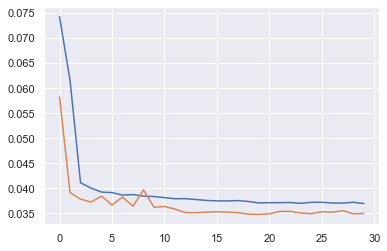

In [65]:
plt.plot(losses)
plt.plot(validlosses)

In [69]:
seed_everything()
idx_date = 0
it = iter(loaderZtest[test_date[idx_date]])
x,y = next(it)

test = PredictToPredict(modetrained,x,540)

<AxesSubplot:>

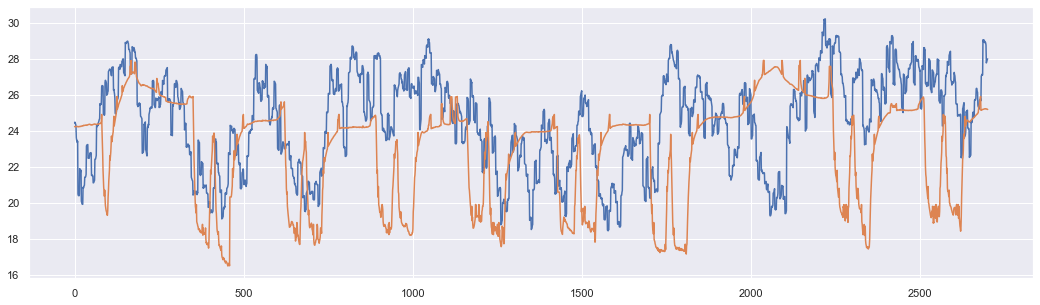

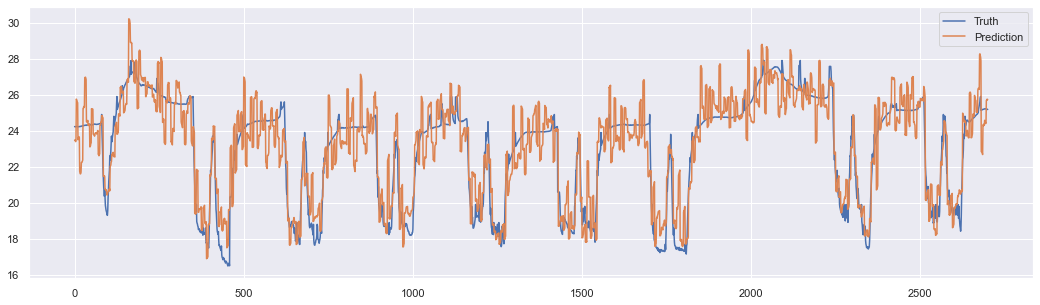

In [70]:
ft_idx = 3
maxi = scalersX[myfloor].data_max_[ft_idx]
mini = scalersX[myfloor].data_min_[ft_idx]
may = [date for date in test_date if '2019-09' in date]
resultpd = PredictionMultipleDate(modetrained,test_date,may[0], may[10],loaderZtest,lookahead, scalersX, myfloor, ft_idx)
truth2 = resultpd["Truth"].values
plt.figure(figsize=(18,5))
plt.plot(test[-1,lookback:,:].detach().numpy().squeeze()*(maxi-mini) + mini)
plt.plot(truth2)
resultpd[["Truth","Prediction"]].plot(figsize=(18,5))#,title="Model_"+str(indexroom))

In [20]:
def Prediction(model,sample):
    model.eval()
    with torch.no_grad():
        pred = model(sample)
        #pred = pred.permute(1,0,2).squeeze(-1)
    return pred

def PredictToPredict(model, sample,nb_pred):
    init=sample
    #sample = sample.permute(1,0,2)
    #print(sample.shape)
    #seed_everything()
    for t in range(1,nb_pred+1):
        series = Prediction(model, sample)
        #print(series.shape)
        init = torch.cat((init, series.unsqueeze(-1)), dim=1)
        sample = init[:,-lookback:,:]
        #print(sample.shape)
        #sample = sample.permute(1,0,2)
        #print(sample.shape)
    return init